# 기계학습 특강 (11주차) 11월16일
> 순환신경망– abc예제, abdc예제, abcde예제, AbAcAd예제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Machine Learning, 순환신경망, abdc예제, abcde예제, AbAcAd예제]

## import

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Define some funtions

In [2]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

## Exam4: AbAcAd (2)

### data

`-` 기존의 정리방식

In [ ]:
txt = list('AbAcAd')*100
txt[:10]

In [ ]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [ ]:
txt_x[:5],txt_y[:5]

In [ ]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

In [ ]:
x,y

### 순환신경망 구현1 (손으로 직접구현) -- 리뷰

`(1)` 숙성담당 네트워크

In [ ]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) 
        self.h2h = torch.nn.Linear(2,2) 
        self.tanh = torch.nn.Tanh()
    def forward(self,x,hidden):
        hidden = self.tanh(self.i2h(x)+self.h2h(hidden))
        return hidden

In [ ]:
torch.manual_seed(43052)
rnncell = rNNCell() # 숙성담당 네트워크 

`(2)` 조리담당 네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수, 옵티마이저 설계 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습 (6분정도 걸림)

In [ ]:
T = len(x) 
for epoc in range(5000): 
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht) 
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [ ]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]]) 

In [ ]:
yhat = soft(cook(hidden))
yhat

In [ ]:
plt.matshow(yhat.data[-15:],cmap='bwr')

### 순환신경망 구현2 (with RNNCell, hidden node 2)

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

#### 구현1과 같은 초기값 (확인용) 

`(1)` 숙성네트워크

In [ ]:
torch.manual_seed(43052)
_rnncell = rNNCell() # 숙성담당 네트워크 

In [ ]:
rnncell = torch.nn.RNNCell(4,2)

`rNNCell()` 는 사실 `torch.nn.RNNCell()`와 같은 동작을 하도록 설계를 하였음. 같은동작을 하는지 확인하기 위해서 동일한 초기상태에서 `rNNCell()`에 의하여 학습된 결과와 `torch.nn.RNNCell()`에 의하여 학습된 결과를 비교해보자.

In [ ]:
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.weight_hh.data = _rnncell.h2h.weight.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data

`(2)` 조리네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [ ]:
hidden = torch.zeros(T,2) 

In [ ]:
# t=0 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
# t=1~T 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [ ]:
yhat = soft(cook(hidden))
yhat

In [ ]:
plt.matshow(yhat[:15].data,cmap='bwr')

In [ ]:
plt.matshow(yhat[-15:].data,cmap='bwr')

#### 새로운 초기값

`(1)` 숙성네트워크

In [ ]:
torch.manual_seed(43052)
torch.nn.RNNCell(4,2)

`(2)` 조리네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

### 순환신경망 구현3 (with RNN, hidden node 2) -- 성공 

(예비학습)

`-` 네트워크학습이후 yhat을 구하려면 번거로웠음 

```Python
hidden = torch.zeros(T,2) 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])
yhat = soft(cook(hidden))
```

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [ ]:
rnn = torch.nn.RNN(4,2)

In [ ]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [ ]:
rnn(x,_water), hidden

In [ ]:
soft(cook(rnn(x,_water)[0]))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [ ]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [ ]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4,2)

In [ ]:
rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

`(2)` 조리네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,2) 
for epoc in range(5000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [ ]:
yhat = soft(output)

In [ ]:
plt.matshow(yhat.data[:15],cmap='bwr')

- 처음은 좀 틀렸음 ㅎㅎ

In [ ]:
plt.matshow(yhat.data[-15:],cmap='bwr')

- 뒤에는 잘맞음 

**실전팁: `_water` 대신에 `hT`를 대입 (사실 큰 차이는 없음)**

In [ ]:
rnn(x[:6],_water),rnn(x[:6],hT)

`(6)` 시각화2: hidden, yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 히든노드의 해석이 어려움. 

### 순환신경망 구현4 (with RNN, hidden node 3) -- 성공 

`(1)` 숙성네트워크~ `(2)` 조리네트워크

In [ ]:
torch.manual_seed(2) #1 
rnn = torch.nn.RNN(4,3) 
cook = torch.nn.Linear(3,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [ ]:
yhat = soft(output)

In [ ]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 세번째 히든노드 = 대소문자를 구분
- 1,2 히든노드 = bcd를 구분 

## GPU 실험

### 20000 len + 20 hidden nodes

***cpu***

In [ ]:
x = torch.randn([20000,4]) 
y = torch.randn([20000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([20000,4]).to("cuda:0")
y = torch.randn([20000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

- 왜 빠른지? 

### 20000 len + 20 hidden nodes + 역전파주석처리 

***cpu***

In [ ]:
x = torch.randn([20000,4]) 
y = torch.randn([20000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([20000,4]).to("cuda:0")
y = torch.randn([20000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

### 2000 len + 20 hidden nodes 

***cpu***

In [ ]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

### 2000 len + 20 hidden nodes + 역전파주석처리

***cpu***

In [ ]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,20) 
linr = torch.nn.Linear(20,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,20).to("cuda:0")
linr = torch.nn.Linear(20,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,20).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

### 2000 len + 5000 hidden nodes 

***cpu***

In [ ]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,1000) 
linr = torch.nn.Linear(1000,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,1000).to("cuda:0")
linr = torch.nn.Linear(1000,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

### 2000 len + 5000 hidden nodes + 역전파주석처리

***cpu***

In [ ]:
x = torch.randn([2000,4]) 
y = torch.randn([2000,4]) 

In [ ]:
rnn = torch.nn.RNN(4,1000) 
linr = torch.nn.Linear(1000,4) 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000)
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

***gpu***

In [ ]:
x = torch.randn([2000,4]).to("cuda:0")
y = torch.randn([2000,4]).to("cuda:0")

In [ ]:
rnn = torch.nn.RNN(4,1000).to("cuda:0")
linr = torch.nn.Linear(1000,4).to("cuda:0")
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()))
loss_fn = torch.nn.MSELoss() 

In [ ]:
t1 = time.time()
for epoc in range(100):
    ## 1 
    _water = torch.zeros(1,1000).to("cuda:0")
    hidden, hT = rnn(x,_water) 
    yhat = linr(hidden) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    #loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2 - t1 

### 실험결과 요약 

|len |# of hidden nodes | backward |cpu | gpu| ratio| 
|:-:|:-:|:-:|:-:|:-:|:-:|
|20000 | 20| O | 93.02 | 3.26 | 28.53 |
|20000 | 20| X | 18.85 | 1.29 | 14.61 | 
|2000 | 20| O | 6.53 | 0.75 | 8.70 | 
|2000 | 20| X | 1.25 | 0.14 | 8.93 |
|2000 | 1000| O | 58.99 | 4.75 | 12.41 | 
|2000 | 1000| X | 13.16 | 2.29 | 5.74 |

## Exam5: abcabC

### data 

In [16]:
txt = list('abcabC')*100
txt[:8]

['a', 'b', 'c', 'a', 'b', 'C', 'a', 'b']

In [17]:
txt_x = txt[:-1] 
txt_y = txt[1:]

In [18]:
mapping = {'a':0,'b':1,'c':2,'C':3} 
x= torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y= torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [19]:
x = x.to("cuda:0")
y = y.to("cuda:0") 

In [20]:
x.shape

torch.Size([599, 4])

### RNN 

- bc
- bC
- b의 수준이 2개 
- abc
- amC
- 문맥 고려해서 $\to$ hiddenlayer = 3

In [21]:
torch.manual_seed(43052) 
rnn = torch.nn.RNN(4,3) 
linr = torch.nn.Linear(3,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+ list(linr.parameters()))

In [22]:
rnn.to("cuda:0") 
linr.to("cuda:0")

Linear(in_features=3, out_features=4, bias=True)

`-` 3000 epochs

In [23]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [24]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

- 어차피 시각화하려면 cpu에 있어야해
- 나중 기억!

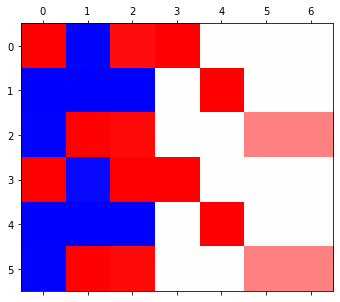

In [25]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 6000 epochs

- 3: a일 확률
- 4: b일 확률
- 5: c일 확률
- 6: C일 확률

In [26]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [27]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

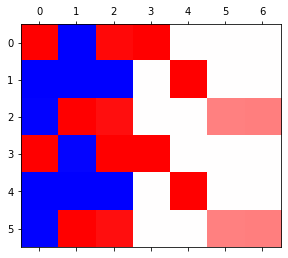

In [28]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 9000 epochs

In [29]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [30]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

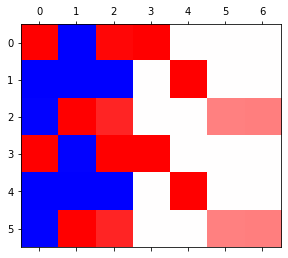

In [31]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 12000 epochs

In [32]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [33]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

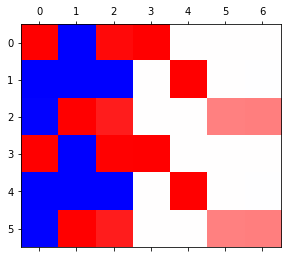

In [34]:
plt.matshow(combinded[-6:],cmap='bwr')

`-` 15000 epochs

In [35]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, hT = rnn(x,_water)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [36]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

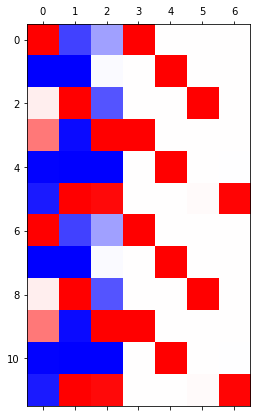

In [39]:
plt.matshow(combinded[-12:],cmap='bwr')

- 15,000번 정도 하니 c와 C를 구분하는 모습
- hidden layer(0,1,2)의 색 순서에 따라 문맥상 다른 것을 알 수 있고 학습도 되는 모습을 볼 수 있다.

### LSTM 

`-` LSTM 

In [40]:
torch.manual_seed(43052) 
lstm = torch.nn.LSTM(4,3) 
linr = torch.nn.Linear(3,4) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(linr.parameters()))

In [41]:
lstm.to("cuda:0") 
linr.to("cuda:0")

Linear(in_features=3, out_features=4, bias=True)

`-` 3000 epochs

In [42]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, (hT,cT) = lstm(x,(_water,_water))
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [43]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

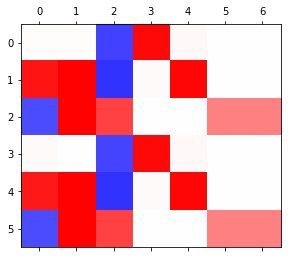

In [44]:
plt.matshow(combinded[-6:],cmap='bwr',vmin=-1,vmax=1)

- 하얀부분이 0 파란 부분이 -1 빨간 부분이 +1

`-` 6000 epochs

In [45]:
for epoc in range(3000):
    ## 1 
    _water = torch.zeros(1,3).to("cuda:0")
    hidden, (hT,cT) = lstm(x,(_water,_water))
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [46]:
yhat = soft(output)
combinded  = torch.concat([hidden,yhat],axis=1).data.to("cpu")

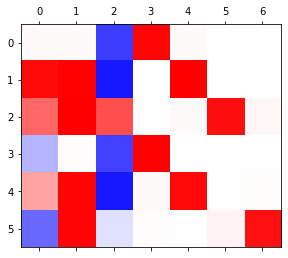

In [47]:
plt.matshow(combinded[-6:],cmap='bwr',vmin=-1,vmax=1)

- rnn에 비해 lstm은 조금 돌려도 어느정도 비교 잘 해낸다

### RNN vs LSTM 성능비교실험

`-` RNN 

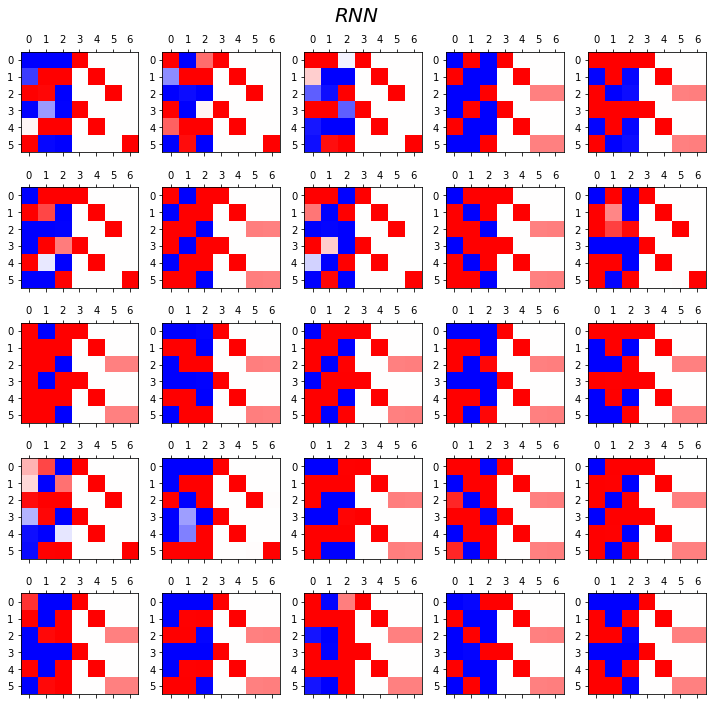

In [48]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,3).to("cuda:0")
        linr = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,3).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, hT = rnn(x,_water)
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-6:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$RNN$",size=20)
fig.tight_layout()

`-` LSTM

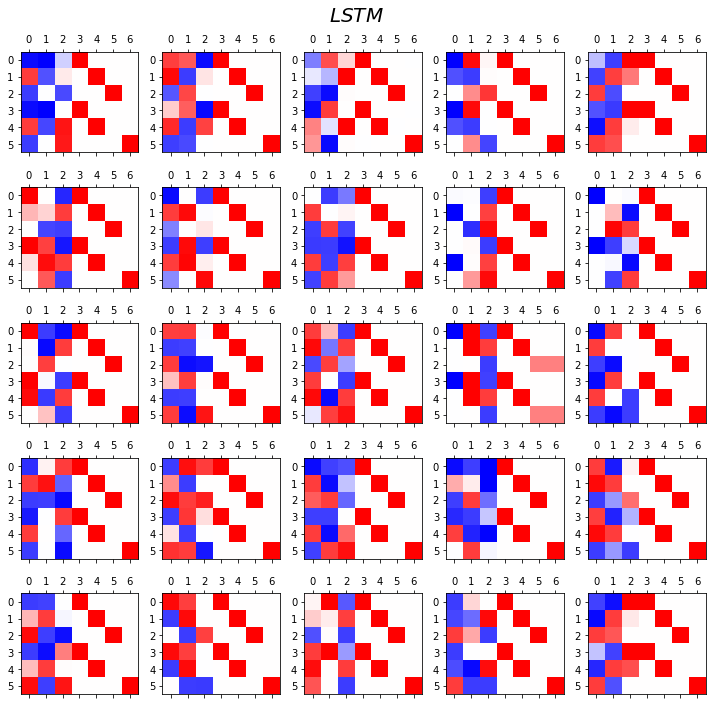

In [49]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,3).to("cuda:0")
        linr = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,3).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, (hT,cT) = lstm(x,(_water,_water))
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-6:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$LSTM$",size=20)
fig.tight_layout()

- lstm이 rnn보다 이런 상황에서는 더 잘 학습해낸다.
- linear 의 hiddenlayer로 구분되어 있다.

## Exam6: abcdabcD

### data

In [50]:
txt = list('abcdabcD')*100
txt[:8]

['a', 'b', 'c', 'd', 'a', 'b', 'c', 'D']

In [51]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [52]:
mapping = {'a':0, 'b':1, 'c':2, 'd':3, 'D':4}
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [53]:
x=x.to("cuda:0")
y=y.to("cuda:0")

### RNN vs LSTM 성능비교실험

`-` RNN 

In [ ]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(5,4).to("cuda:0")
        linr = torch.nn.Linear(4,5).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,4).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, hT = rnn(x,_water)
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-8:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$RNN$",size=20)
fig.tight_layout()

`-` LSTM

In [ ]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(5,4).to("cuda:0")
        linr = torch.nn.Linear(4,5).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)
        _water = torch.zeros(1,4).to("cuda:0")
        for epoc in range(3000):
            ## 1
            hidden, (hT,cT) = lstm(x,(_water,_water))
            output = linr(hidden)
            ## 2
            loss = loss_fn(output,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        yhat=soft(output)    
        combind = torch.concat([hidden,yhat],axis=1)
        ax[i][j].matshow(combind.to("cpu").data[-8:],cmap='bwr',vmin=-1,vmax=1)
fig.suptitle(r"$LSTM$",size=20)
fig.tight_layout()

`-` 관찰1: LSTM이 확실히 장기기억에 강하다. 

`-` 관찰2: LSTM은 hidden에 0이 잘 나온다. 

- 사실 확실히 구분되는 특징을 판별할때는 -1,1 로 히든레이어 값들이 설정되면 명확하다. 
- 히든레이어에 -1~1사이의 값이 나온다면 애매한 판단이 내려지게 된다. 
- 그런데 이 애매한 판단이 어떻게 보면 문맥의 뉘앙스를 이해하는데 더 잘 맞다.
- 그런데 RNN은 -1,1로 셋팅된 상황에서 -1~1로의 변화가 더디다는 것이 문제임. 

## LSTM의 계산과정

### data: abaB

In [55]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

- ab
- aB
- 로서 a의 수준이 2개로 나뉨 $\to$ hidden node = 2

In [56]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [57]:
mapping = {'a':0, 'b':1, 'B':2}
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

### 1 epoch ver1 (with torch.nn.LSTMCell)

In [58]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [59]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

- 데이터 적으니까 cpu로 할 것임

In [60]:
ht,ct 

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

- hidden node가 많고 len 이 클수록 GPU가 효율이 좋다

### 1 epoch ver2 (완전 손으로 구현) 

#### ***t=0 $\to$ t=1***

`-` lstm_cell 을 이용한 계산 (결과비교용)

In [61]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [62]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(1):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [63]:
ht,ct 

(tensor([[-0.0541,  0.0892]], grad_fn=<MulBackward0>),
 tensor([[-0.1347,  0.2339]], grad_fn=<AddBackward0>))

- 이런결과를 어떻게 만드는걸까? 
- <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>

$i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi})$

$f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})$

$g_t = \tanh (W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg})$

$o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{hg})$

$o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})$

$c_t = f_t \odot c_{t-1} + i_t \odot g_t$

$h_t = o_t \odot \tanh (c_t)$

$\sigma = \text{ Sigmoid }$

$x_t, h_{t-1} \underrightarrow{lin} \text{ }\circ  \text{ }\underrightarrow{sig} \text{ }i_t$

$x_t, h_{t-1} \underrightarrow{lin}  \text{ }\square \text{ } \underrightarrow{sig} \text{ }f_t$

$x_t, h_{t-1} \underrightarrow{lin}  \text{ }\star  \text{ } \underrightarrow{tanh} \text{ }g_t$

$x_t, h_{t-1} \underrightarrow{lin}  \text{ } \triangleleft  \text{ }\underrightarrow{sig} \text{ }o_t$ 

$x_t, h_{t-1} \underrightarrow{lin} \text{ }\circ \text{ , } \square \text{, } \star \text{, } \triangleleft \text{ } \to \sigma(circ) \text{, }\sigma(\square) \text{ , }\tanh(\star)\text{ , } \sigma(\triangleleft) \sim i_t, f_t, g_t, o_t$

- 위에 나온 W가 어떻게 계산되나

weight_ih_l[k] – the learnable input-hidden weights of the $\text{k}^{th}$ layer $(W_ii|W_if|W_ig|W_io)$, of shape (4*hidden_size, input_size) for $k = 0$. Otherwise, the shape is (4*hidden_size, num_directions * hidden_size). If proj_size > 0 was specified, the shape will be (4*hidden_size, num_directions * proj_size) for $k > 0$

weight_hh_l[k] – the learnable hidden-hidden weights of the \text{k}^{th}$layer $(W_hi|W_hf|W_hg|W_ho)$, of shape (4*hidden_size, hidden_size). If proj_size > 0 was specified, the shape will be (4*hidden_size, proj_size).

`-` 직접계산 

- $o_t$ = output_gate
- $f_t$ = forget_gate
- $i_t$ = input_gate

In [13]:
ht = torch.zeros(1,2)
ct = torch.zeros(1,2)

In [66]:
_ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
_ifgo

tensor([[ 0.0137,  0.1495,  0.0879,  0.6436, -0.2615,  0.3974, -0.3506, -0.4550]],
       grad_fn=<AddBackward0>)

$\circ \text{ , } \square \text{, } \star \text{, } \triangleleft $각 두 개씩

In [67]:
input_gate = sig(_ifgo[:,0:2])
forget_gate = sig(_ifgo[:,2:4])
gt = tanh(_ifgo[:,4:6])
output_gate = sig(_ifgo[:,6:8])

In [68]:
ct = forget_gate * ct + input_gate * gt
ht = output_gate * tanh(ct)

In [69]:
ht,ct

(tensor([[-0.0812,  0.1327]], grad_fn=<MulBackward0>),
 tensor([[-0.1991,  0.3563]], grad_fn=<AddBackward0>))

#### ***t=0 $\to$ t=T***

In [70]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [71]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        
        ## lstm_cell step1: calculate _ifgo 
        _ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
        ## lstm_cell step2: decompose _ifgo 
        input_gate = sig(_ifgo[:,0:2])
        forget_gate = sig(_ifgo[:,2:4])
        gt = tanh(_ifgo[:,4:6])
        output_gate = sig(_ifgo[:,6:8])
        ## lstm_cell step3: calculate ht,ct 
        ct = forget_gate * ct + input_gate * gt
        ht = output_gate * tanh(ct)
        
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [72]:
ht,ct

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

### 1 epoch ver3 (with torch.nn.LSTM)

In [73]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2)
linr = torch.nn.Linear(2,3) 

In [74]:
lstm = torch.nn.LSTM(3,2) 

In [75]:
lstm.weight_hh_l0.data = lstm_cell.weight_hh.data 
lstm.bias_hh_l0.data = lstm_cell.bias_hh.data 
lstm.weight_ih_l0.data = lstm_cell.weight_ih.data 
lstm.bias_ih_l0.data = lstm_cell.bias_ih.data 

- 초기화된 가중치값들로 덮어씌우기

In [76]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(linr.parameters()), lr=0.1) 

In [77]:
_water = torch.zeros(1,2) 
for epoc in range(1): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    # ## step2
    # loss = loss_fn(output,y) 
    # ## step3
    # loss.backward()
    # ## step4 
    # optimizr.step()
    # optimizr.zero_grad() 

In [78]:
ht,ct

(tensor([[-0.0406,  0.2505]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.0975,  0.7134]], grad_fn=<SqueezeBackward1>))

## LSTM은 왜 강한가? 

### data: abaB

In [79]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

In [80]:
n_words = 3

In [81]:
mapping = {'a':0, 'b':1, 'B':2}

In [82]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [83]:
txt_x[:10],txt_y[:10]

(['a', 'b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b'],
 ['b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b', 'a'])

In [84]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [85]:
x,y

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]),
 tensor([[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         ...,
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]]))

### 1000 epoch 

In [86]:
torch.manual_seed(43052) 
lstm = torch.nn.LSTM(3,2) 
linr = torch.nn.Linear(2,3) 

In [87]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(linr.parameters()),lr=0.1)

In [88]:
_water = torch.zeros(1,2) 
for epoc in range(1000): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    ## step2
    loss = loss_fn(output,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

### 시각화 

In [89]:
T = len(x)
input_gate = torch.zeros(T,2)
forget_gate = torch.zeros(T,2)
output_gate = torch.zeros(T,2)
g = torch.zeros(T,2)
cell = torch.zeros(T,2)
h = torch.zeros(T,2) 

- 변수를 담을 빈 셋 설정

In [90]:
for t in range(T): 
    ## 1: calculate _ifgo 
    _ifgo = x[[t]] @ lstm.weight_ih_l0.T + h[[t]] @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0 
    ## 2: decompose _ifgo 
    input_gate[[t]] = sig(_ifgo[:,0:2])
    forget_gate[[t]] = sig(_ifgo[:,2:4])
    g[[t]] = tanh(_ifgo[:,4:6])
    output_gate[[t]] = sig(_ifgo[:,6:8])
    ## 3: calculate ht,ct 
    cell[[t]] = forget_gate[[t]] * cell[[t]] + input_gate[[t]] * g[[t]]
    h[[t]] = output_gate[[t]] * tanh(cell[[t]])

In [91]:
combinded1 = torch.concat([input_gate,forget_gate,output_gate],axis=1)
combinded2 = torch.concat([g,cell,h,soft(output)],axis=1)

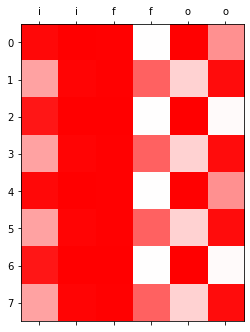

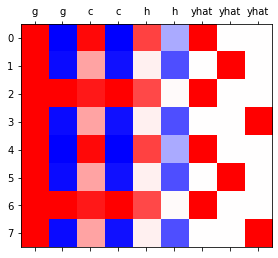

In [92]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

- 상단그림은 게이트의 값들만 시각화, 하단그림은 게이트 이외의 값들을 시각화 

### 시각화의 해석I 

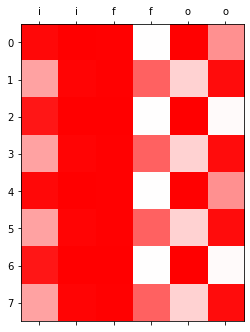

In [94]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);

`-` input_gate, forget_gate, output_gate는 모두 0~1 사이의 값을 가진다. 

`-` 이 값들은 각각 모두 ${\boldsymbol g}_t, {\boldsymbol c}_{t-1}, \tanh({\boldsymbol c}_t)$에 곱해진다. 따라서 input_gate, forget_gate, output_gate 는 gate의 역할로 비유가능하다. (1이면 통과, 0이면 차단)

- input_gate: ${\boldsymbol g}_t$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 
- forget_gate: ${\boldsymbol c}_{t-1}$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 
- output_gate: $\tanh({\boldsymbol c}_t)$의 값을 얼만큼 통과시킬지 0~1사이의 숫자로 결정 

(서연 필기)

- 값들이 0과 1사이의 값을 가진다
- 파 -1 흰 0 빨 1
- 0 곱하면 어떤 값이든 0이 되니까 차단한다 표현

### 시각화의 해석II

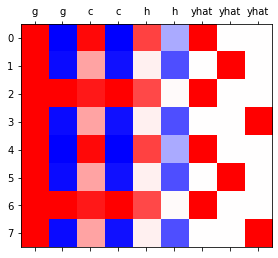

In [95]:
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

`-` 결국 ${\boldsymbol g}_t\to {\boldsymbol c}_t \to {\boldsymbol h}_t \to \hat{\boldsymbol y}$ 의 느낌이다. (${\boldsymbol h}_t$를 계산하기 위해서는 ${\boldsymbol c}_t$가 필요했고 ${\boldsymbol c}_t$를 계산하기 위해서는 ${\boldsymbol c}_{t-1}$과 ${\boldsymbol g}_t$가 필요했음) 

- ${\boldsymbol h}_t= \tanh({\boldsymbol c}_t) \odot {\boldsymbol o}_t$
- ${\boldsymbol c}_t ={\boldsymbol c}_{t-1} \odot {\boldsymbol f}_t + {\boldsymbol g}_{t} \odot {\boldsymbol i}_t$

`-` ${\boldsymbol g}_t,{\boldsymbol c}_t,{\boldsymbol h}_t$ 모두 ${\boldsymbol x}_t$의 정보를 숙성시켜 가지고 있는 느낌이 든다. 

`-` ${\boldsymbol g}_t$ 특징: 보통 -1,1 중 하나의 값을 가지도록 학습되어 있다. (마치 RNN의 hidden node처럼!) 

- $\boldsymbol{g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg}+ {\boldsymbol b}_{ig}+{\boldsymbol b}_{hg})$

`-` ${\boldsymbol c}_t$ 특징: ${\boldsymbol g}_t$와 매우 비슷하지만 약간 다른값을 가진다. 그래서 ${\boldsymbol g}_t$와는 달리 -1,1 이외의 값도 종종 등장. 

In [96]:
print("first row: gt={}, ct={}".format(g[-8].data, cell[-8].data))
print("second row: gt={}, ct={}".format(g[-7].data, cell[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373])


`-` ${\boldsymbol h}_t$ 특징: (1) ${\boldsymbol c}_t$의 느낌이 있음 하지만 약간의 변형이 있음. (2) -1~1 사이에의 값을 훨씬 다양하게 가진다. (tanh때문)

(서연 필기)

- comparison of g,c part 
    - 보니까 빨간 색은 1에 가까운 값, 파란색은 -1에 가까운 값들을 띄었다.
    - 그리고 연한 빨간색인 부분은 0.3592로 낮았고, g부분과 c부분이 열별로 보았을 때 달랐다

In [97]:
print("first row: gt={}, ct={}, ht={}".format(g[-8].data, cell[-8].data,h[-8].data))
print("second row: gt={}, ct={}, ht={}".format(g[-7].data, cell[-7].data,h[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984]), ht=tensor([ 0.7370, -0.3323])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373]), ht=tensor([ 0.0604, -0.6951])


(서연 필기)

- comparison of c,h part 
    - h는 c와 무관해보이지 않는다.
    - 단지 어떤 변형이 있는 것 같다.

`-` 예전의문 해결

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
- 그 이유: RRN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는 경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한 방식으로 학습되는 경우가 많았음. 
- 왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh 때문 

## 여기서부너 3부 1:15분! 다시 듣기

### LSTM의 알고리즘 리뷰 I (수식위주)

**(step1)** calculate ${\tt ifgo}$

${\tt ifgo} = {\boldsymbol x}_t  \big[{\bf W}_{ii} | {\bf W}_{if}| {\bf W}_{ig} |{\bf W}_{io}\big] + {\boldsymbol h}_{t-1}  \big[ {\bf W}_{hi}|{\bf W}_{hf} |{\bf W}_{hg} | {\bf W}_{ho} \big] + bias$

$=\big[{\boldsymbol x}_t{\bf W}_{ii} + {\boldsymbol h}_{t-1}{\bf W}_{hi} ~\big|~ {\boldsymbol x}_t{\bf W}_{if}+ {\boldsymbol h}_{t-1}{\bf W}_{hf}~ \big|~ {\boldsymbol x}_t{\bf W}_{ig} + {\boldsymbol h}_{t-1}{\bf W}_{hg}  ~\big|~ {\boldsymbol x}_t{\bf W}_{io} + {\boldsymbol h}_{t-1}{\bf W}_{ho} \big] + bias$

참고: 위의 수식은 아래코드에 해당하는 부분

```Python
ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
```

**(step2)** decompose ${\tt ifgo}$ and get ${\boldsymbol i}_t$, ${\boldsymbol f}_t$, ${\boldsymbol g}_t$, ${\boldsymbol o}_t$

${\boldsymbol i}_t = \sigma({\boldsymbol x}_t {\bf W}_{ii} + {\boldsymbol h}_{t-1} {\bf W}_{hi} +bias )$ 

${\boldsymbol f}_t = \sigma({\boldsymbol x}_t {\bf W}_{if} + {\boldsymbol h}_{t-1} {\bf W}_{hf} +bias )$ 

${\boldsymbol g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg} +bias )$ 

${\boldsymbol o}_t = \sigma({\boldsymbol x}_t {\bf W}_{io} + {\boldsymbol h}_{t-1} {\bf W}_{ho} +bias )$ 

**(step3)** calculate ${\boldsymbol c}_t$ and ${\boldsymbol h}_t$

${\boldsymbol c}_t = {\boldsymbol i}_t \odot {\boldsymbol g}_t+ {\boldsymbol f}_t \odot {\boldsymbol c}_{t-1}$

${\boldsymbol h}_t = \tanh({\boldsymbol o}_t \odot {\boldsymbol c}_t)$

### LSTM의 알고리즘 리뷰 II (느낌위주)

- 이해 및 암기를 돕기위해서 비유적으로 설명한 챕터입니다..

`-` 느낌1: RNN이 콩물에서 간장을 한번에 숙성시키는 방법이라면 LSTM은 콩물에서 간장을 3차로 나누어 숙성하는 느낌이다. 

- 콩물: ${\boldsymbol x}_t$
- 1차숙성: ${\boldsymbol g}_t$
- 2차숙성: ${\boldsymbol c}_t$ 
- 3차숙성: ${\boldsymbol h}_t$ 

`-` 느낌2: ${\boldsymbol g}_t$에 대하여

- 계산방법: ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$를 ${\bf W}_{ig}, {\bf W}_{hg}$를 이용해 선형결합하고 $\tanh$를 취한 결과
- RNN에서 간장을 만들던 그 수식에서 $h_t$를 $g_t$로 바꾼것 
- 크게 2가지의 의미를 가진다 (1) 과거와 현재의 결합 (2) 활성화함수 $\tanh$를 적용 

`-` 느낌3: ${\boldsymbol c}_t$에 대하여 (1)

- 계산방법: ${\boldsymbol g}_{t}$와 ${\boldsymbol c}_{t-1}$를 요소별로 선택하고 더하는 과정 
- $g_t$는 (1) 과거와 현재의 결합 (2) 활성화함수 tanh를 적용으로 나누어지는데 이중에서 (1) 과거와 현재의 정보를 결합하는 과정만 해당한다. 차이점은 요소별 선택 후 덧셈
- 이러한 결합을 쓰는 이유? 게이트를 이용하여 과거와 현재의 정보를 제어 (일반적인 설명, 솔직히 내가 좋아하는 설명은 아님)

`-` 느낌4: ${\boldsymbol c}_t$에 대하여 (2) // ${\boldsymbol c}_t$는 왜 과거와 현재의 정보를 제어한다고 볼 수 있는가? 

$t=1$ 시점 계산과정관찰

In [ ]:
input_gate[1],g[1],forget_gate[1],cell[0]

$[0.9,1.0] \odot {\boldsymbol g}_t + [1.0,0.0] \odot {\boldsymbol c}_{t-1}$

- forget_gate는 $c_{t-1}$의 첫번째 원소는 기억하고, 두번째 원소는 잊으라고 말하고 있음 // forget_gate는 과거($c_{t-1}$)의 정보를 얼마나 잊을지 (= 얼마나 기억할지) 를 결정한다고 해석할 수 있다. 
- input_gate는 $g_{t}$의 첫번째 원소와 두번째 원소를 모두 기억하되 두번째 원소를 좀 더 중요하게 기억하라고 말하고 있음 // input_gate는 현재($g_{t}$)의 정보를 얼만큼 강하게 반영할지 결정한다. 
- 이 둘을 조합하면 ${\boldsymbol c}_t$가 현재와 과거의 정보중 어떠한 정보를 더 중시하면서 기억할지 결정한다고 볼 수 있다. 

> 이 설명은 제가 좀 싫어해요, 싫어하는 이유는 (1) "기억의 정도를 조절한다"와 "망각의 정도를 조절한다"는 사실 같은말임. 그래서 forget_gate의 용어가 모호함. (2) 기억과 망각을 조정하는 방식으로 꼭 gate의 개념을 사용해야 하는건 아님

`-` 느낌5: ${\boldsymbol c}_t$에 대하여 (3) 

- 사실상 LSTM 알고리즘의 꽃이라 할 수 있음. 
- LSTM은 long short term memory의 약자임. 기존의 RNN은 장기기억을 활용함에 약점이 있는데 LSTM은 단기기억/장기기억 모두 잘 활용함. 
- LSTM이 장기기억을 잘 활용하는 비법은 바로 ${\boldsymbol c}_t$에 있다.

`-` 느낌6: ${\boldsymbol h}_t$에 대하여
- 계산방법: $\tanh({\boldsymbol c}_t)$를 요소별로 선택 

`-` RNN, LSTM의 변수들 비교 테이블 

||과거정보|현재정보|과거와 현재의 결합방식|활성화|느낌|비고|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|RNN-${\boldsymbol h}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|간장|
|||||||
|LSTM-${\boldsymbol g}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|1차간장|
|LSTM-${\boldsymbol c}_t$|${\boldsymbol c}_{t-1}$|${\boldsymbol g}_t$|$\odot$ $\to$ $+$ |None|2차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|
|LSTM-${\boldsymbol h}_t$|None|${\boldsymbol c}_t$|None|$\tanh$, $\odot$|3차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|


- RNN은 기억할 과거정보가 ${\boldsymbol h}_{t-1}$ 하나이지만 LSTM은 ${\boldsymbol c}_{t-1}$, ${\boldsymbol h}_{t-1}$ 2개이다. 

`-` 알고리즘리뷰 : 

- 콩물,과거3차간장 $\overset{\times,+,\tanh}{\longrightarrow}$ 현재1차간장
- 현재1차간장, 과거2차간장 $\overset{\odot,+,\tanh}{\longrightarrow}$ 현재2차간장
- 현재2차간장 $\overset{\tanh,\odot}{\longrightarrow}$ 현재3차간장

### LSTM이 강한이유 

`-` LSTM이 장기기억에 유리함. 그 이유는 input, forget, output gate 들이 과거기억을 위한 역할을 하기 때문. 

- 비판: 아키텍처에 대한 이론적 근거는 없음. 장기기억을 위하여 꼭 LSTM같은 구조일 필요는 없음. (왜 3차간장을 만들때 tanh를 써야하는지? 게이트는 꼭3개이어야 하는지?)

`-` 저는 사실 아까 살펴본 아래의 이유로 이해하고 있습니다. 

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
- 그 이유: RRN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는 경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한 방식으로 학습되는 경우가 많았음. 
- 왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh 때문 

## 참고자료들 

- <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
- <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>
- <https://arxiv.org/abs/1402.1128>